<a href="https://colab.research.google.com/github/romi-alfonzo/family-rw-detection/blob/main/Family_vs_Safe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Montar Drive


In [23]:
# Montamos Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Instalación de Dependencias


In [24]:
!pip install rarfile
!apt-get install unrar

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [25]:
import os
import numpy as np
import pandas as pd
import rarfile
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

## Rutas del dataset

In [26]:
EXTRACT_PATH = "/content/Pruebas/Pruebas2"
EXTRACT_TO = r"/content/Pruebas"
DATASET_PATH = r"/content/drive/MyDrive/Tesis Carlos y Romina/Notebooks/Datasets/Pruebas2.rar"

encr_dir = r"/content/drive/MyDrive/Tesis Carlos y Romina/Notebooks/Datasets/Pruebas2.rar"
extract_to = r"/content/Pruebas"
extracted_dir = r"/content/Pruebas/Pruebas2"
destination = r"/content/drive/MyDrive/Tesis Carlos y Romina/Notebooks/Results"

## Modelos a entrenar

In [38]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "MLP": MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000),
    "SVM": SVC(probability=True),
    "Decision Tree": DecisionTreeClassifier(),
    "KNN": KNeighborsClassifier(),
    "Random Forest": RandomForestClassifier()
}

## Extraer dataset si no está extraído

In [28]:
import rarfile
import os

if not os.path.exists(extracted_dir):
    with rarfile.RarFile(encr_dir, 'r') as rf:
        rf.extractall(extract_to)
    print(f'Archivo extraído a {extracted_dir}')
else:
    print(f'El archivo ya está extraído en {extracted_dir}')


Archivo extraído a /content/Pruebas/Pruebas2


## Función para extraer Chi-Square como única característica

In [29]:
def extract_features(file_path):
    try:
        with open(file_path, "rb") as f:
            data = f.read()

        # 📌 Histograma de bytes (frecuencia de valores 0-255)
        byte_hist = np.histogram(np.frombuffer(data, dtype=np.uint8), bins=256, range=(0, 255))[0]

        # 📌 Distribución esperada (uniforme)
        expected = np.full_like(byte_hist, np.mean(byte_hist))

        # 📌 Cálculo de Chi-Square
        chi2_stat, _, _, _ = chi2_contingency([byte_hist, expected])

        return [chi2_stat]

    except Exception as e:
        print(f"Error procesando {file_path}: {e}")
        return None

## Obtener características de archivos limpios


In [30]:
clean_features = []
clean_labels = []

clean_data_path = os.path.join(EXTRACT_PATH, "Z-Safe")
for file in os.listdir(clean_data_path):
    file_path = os.path.join(clean_data_path, file)
    features = extract_features(file_path)
    if features:
        clean_features.append(features)
        clean_labels.append(0)  # 0 = Archivo limpio


## Lista de familias de ransomware


In [31]:
families = [f for f in os.listdir(EXTRACT_PATH) if os.path.isdir(os.path.join(EXTRACT_PATH, f)) and f != "Z-Safe"]


## DataFrame para almacenar los resultados


In [32]:
results_df = pd.DataFrame(columns=["Familia"] + list(models.keys()))


## Entrenar un modelo para cada familia

In [48]:
for family in families:
    print(f"🔍 Entrenando modelo para {family}...")

    # 📌 Obtener características de ransomware
    family_features = []
    family_labels = []

    family_path = os.path.join(EXTRACT_PATH, family)
    for file in os.listdir(family_path):
        file_path = os.path.join(family_path, file)
        features = extract_features(file_path)
        if features:
            family_features.append(features)
            family_labels.append(1)  # 1 = Ransomware

    # 📌 Unir datos limpios con la familia actual
    X = np.vstack((clean_features, family_features))
    y = np.array(clean_labels + family_labels)

    # 📌 Normalizar datos
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # 📌 Dividir en entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=42)

    # 📌 Evaluar cada modelo
    scores = {"Familia": family}
    for model_name, model in models.items():
        model.fit(X_train, y_train)  # Entrenar modelo
        y_pred = model.predict(X_test)  # Predecir
        scores[model_name] = accuracy_score(y_test, y_pred)  # Guardar accuracy

    # 📌 Agregar resultados al DataFrame
    results_df = pd.concat([results_df, pd.DataFrame([scores])], ignore_index=True)

🔍 Entrenando modelo para PHOBOS-tiny...
🔍 Entrenando modelo para TESLACRYPT-tiny...


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


🔍 Entrenando modelo para NOTPETYA-tiny...
🔍 Entrenando modelo para CHIMERA-tiny...


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


🔍 Entrenando modelo para CERBER-tiny...


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


🔍 Entrenando modelo para WASTEDLOCKER-tiny...


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


🔍 Entrenando modelo para MEDUZALOCKER-tiny...


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


🔍 Entrenando modelo para CUBA-tiny...
🔍 Entrenando modelo para LORENZ-tiny...


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


🔍 Entrenando modelo para BLACKCAT-tiny...


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


🔍 Entrenando modelo para RYUK-tiny...


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


🔍 Entrenando modelo para SUNCRYPT-tiny...
🔍 Entrenando modelo para CLOP-tiny...
🔍 Entrenando modelo para BADRABBIT-tiny...


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


🔍 Entrenando modelo para DHARMA-tiny...
🔍 Entrenando modelo para MAZE-tiny...


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


🔍 Entrenando modelo para GANDCRAB-tiny...
🔍 Entrenando modelo para BLACKMATTER-tiny...
🔍 Entrenando modelo para JIGSAW-tiny...


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


🔍 Entrenando modelo para LOCKBIT-tiny...
🔍 Entrenando modelo para CRYPTOLOCKER-tiny...


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


🔍 Entrenando modelo para WANNACRY-tiny...


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


🔍 Entrenando modelo para RANSOMEXX-tiny...
🔍 Entrenando modelo para AVOSLOCKER-tiny...
🔍 Entrenando modelo para HELLOKITTY-tiny...
🔍 Entrenando modelo para DARKSIDE-tiny...
🔍 Entrenando modelo para CONTI-tiny...
🔍 Entrenando modelo para SODINOKIBI-tiny...


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


🔍 Entrenando modelo para BLACKBASTA-tiny...
🔍 Entrenando modelo para NETWALKER-tiny...


## Guardar resultados en CSV


In [34]:
results_df.to_csv("ransomware_classification_results.csv", index=False)
print("✅ Resultados guardados en 'ransomware_classification_results.csv'.")

✅ Resultados guardados en 'ransomware_classification_results.csv'.


# Curva ROC

Generando curva ROC para PHOBOS-tiny...


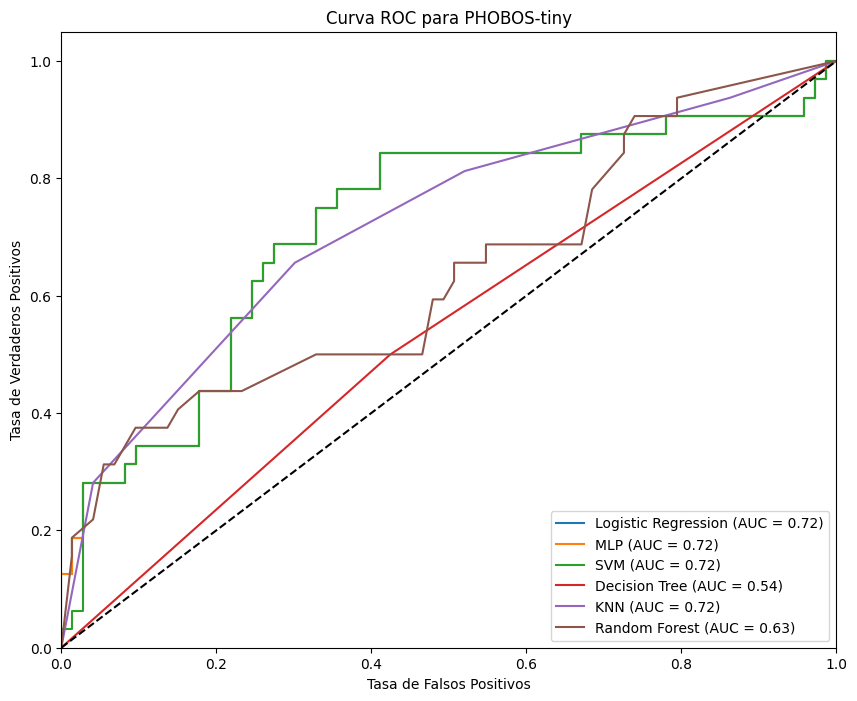

Generando curva ROC para TESLACRYPT-tiny...


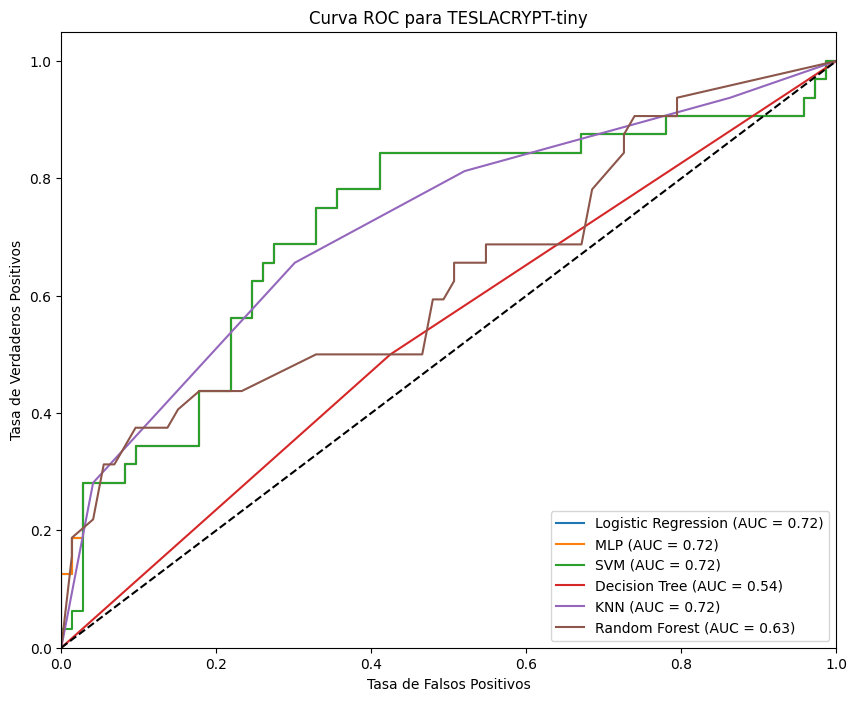

Generando curva ROC para NOTPETYA-tiny...


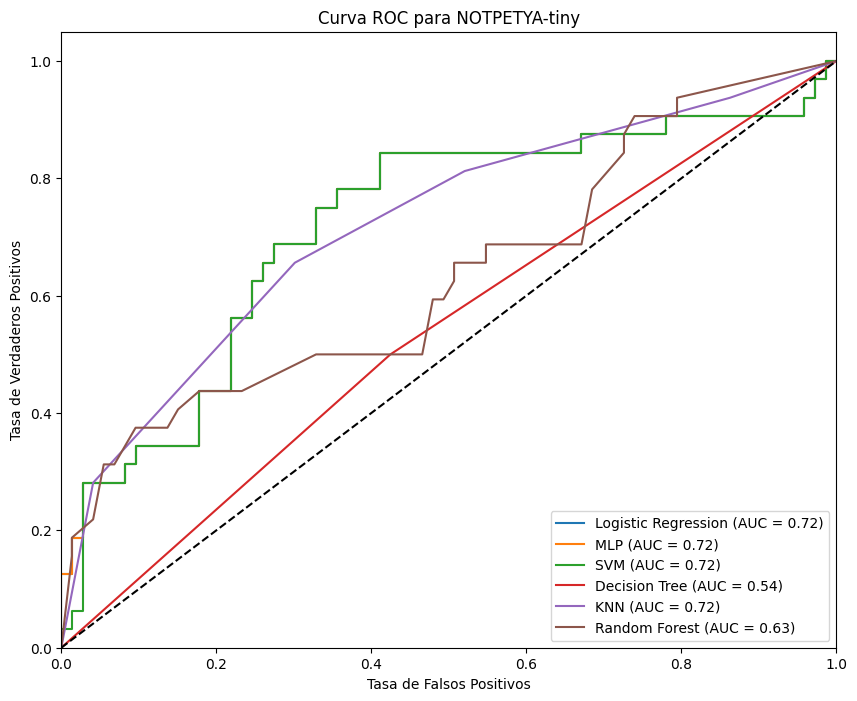

Generando curva ROC para CHIMERA-tiny...


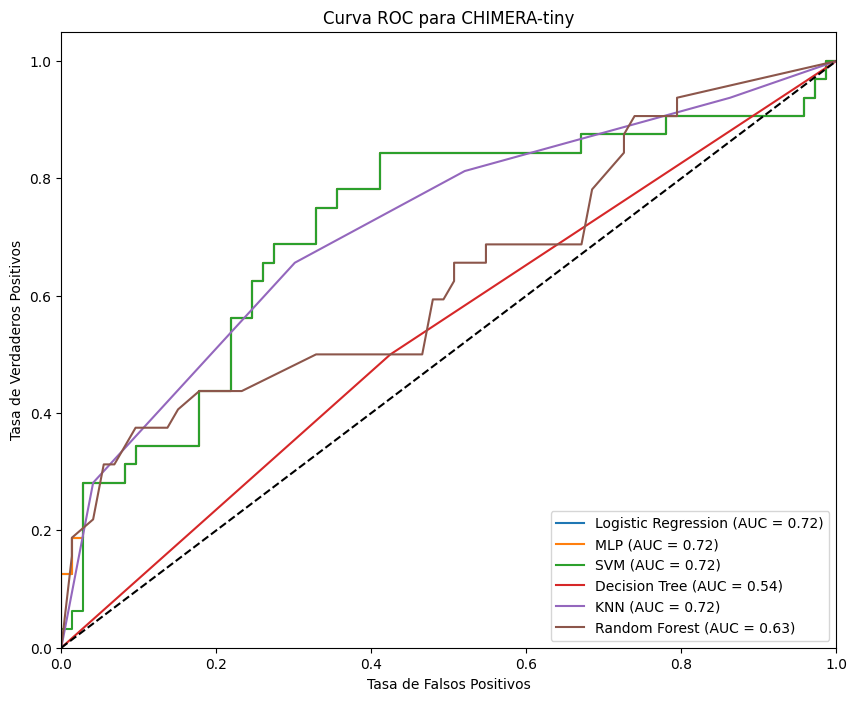

Generando curva ROC para CERBER-tiny...


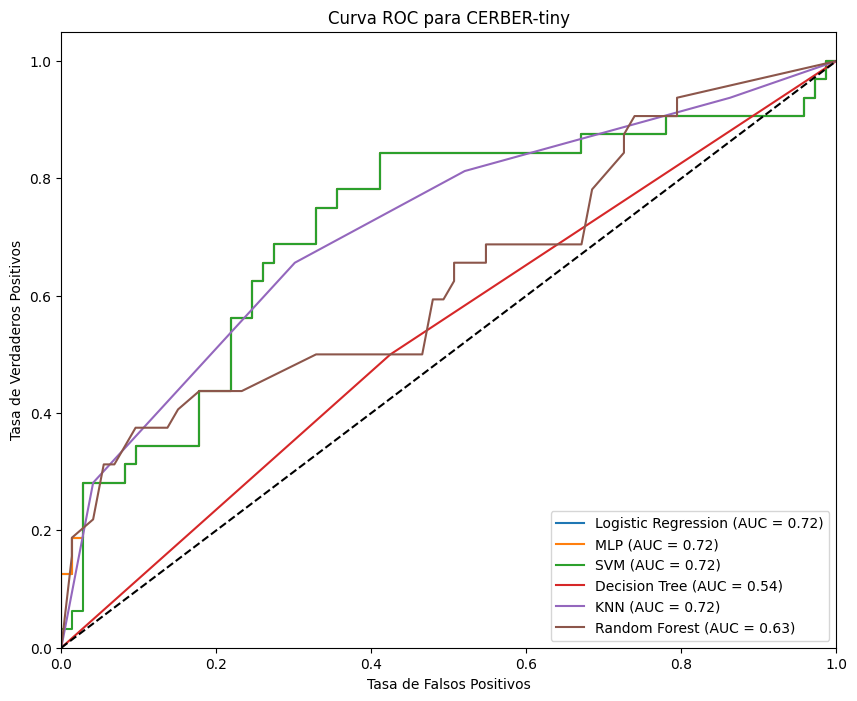

Generando curva ROC para WASTEDLOCKER-tiny...


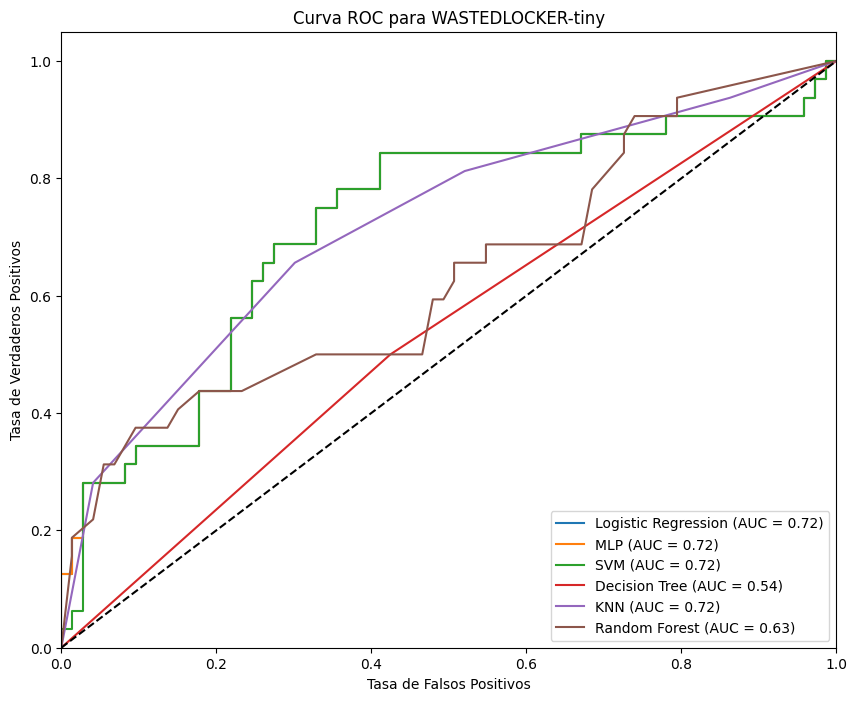

Generando curva ROC para MEDUZALOCKER-tiny...


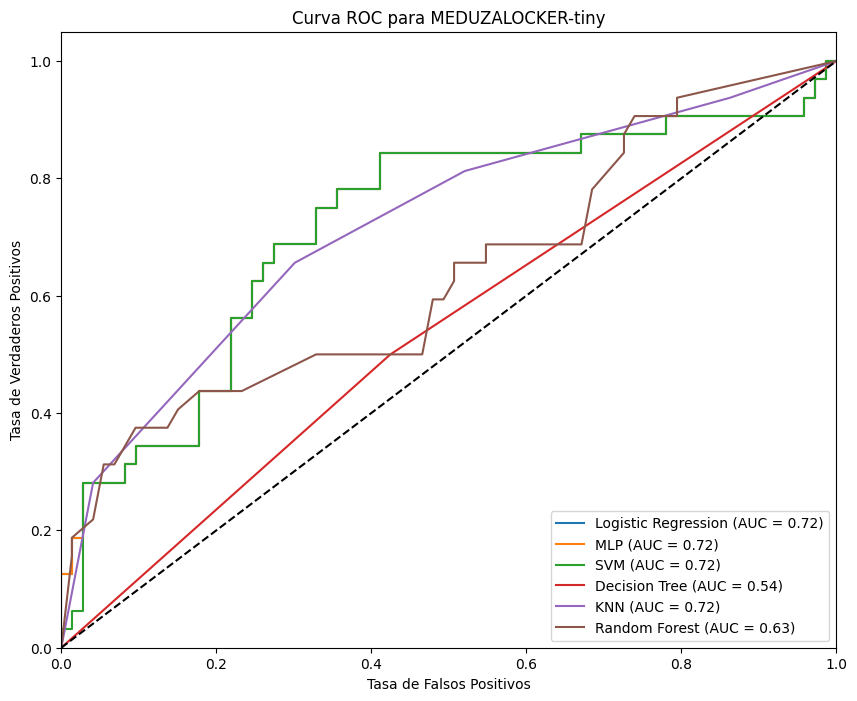

Generando curva ROC para CUBA-tiny...


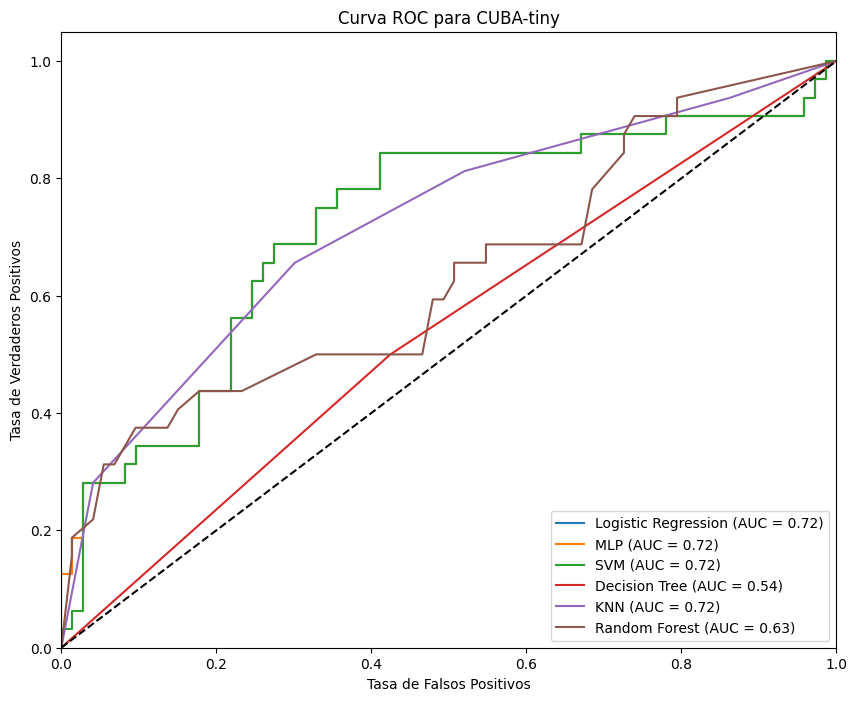

Generando curva ROC para LORENZ-tiny...


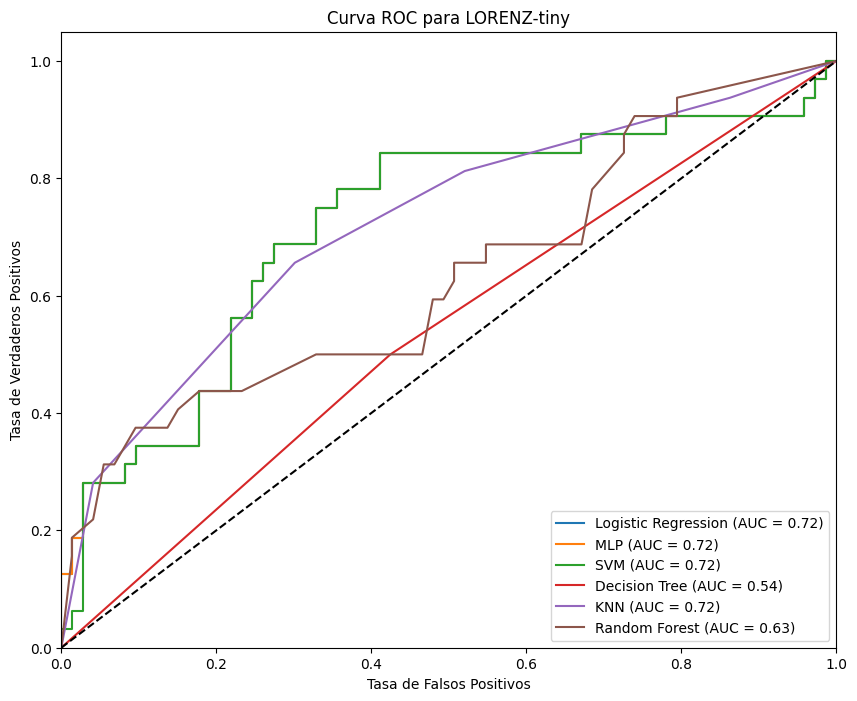

Generando curva ROC para BLACKCAT-tiny...


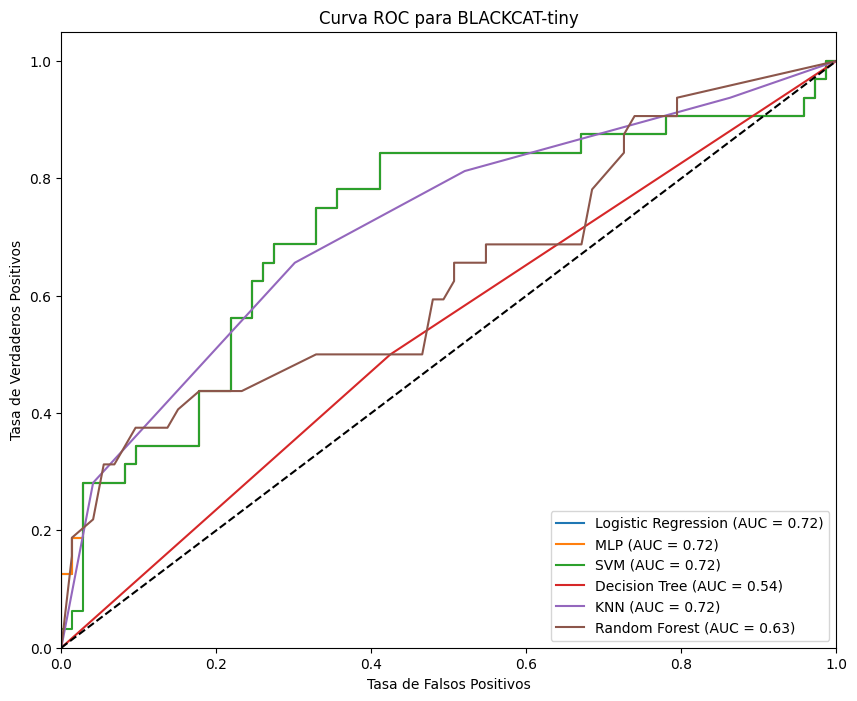

Generando curva ROC para RYUK-tiny...


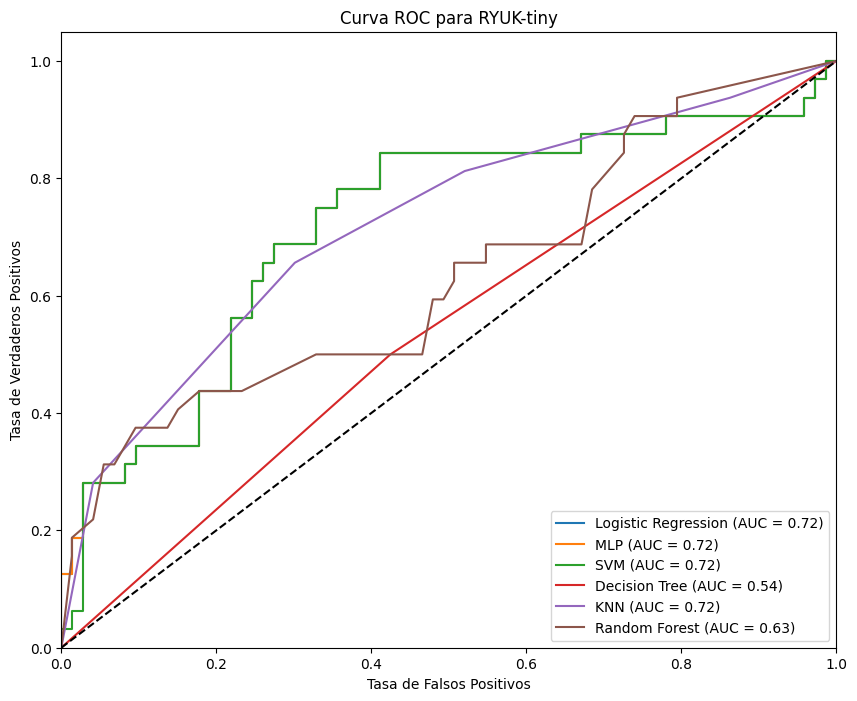

Generando curva ROC para SUNCRYPT-tiny...


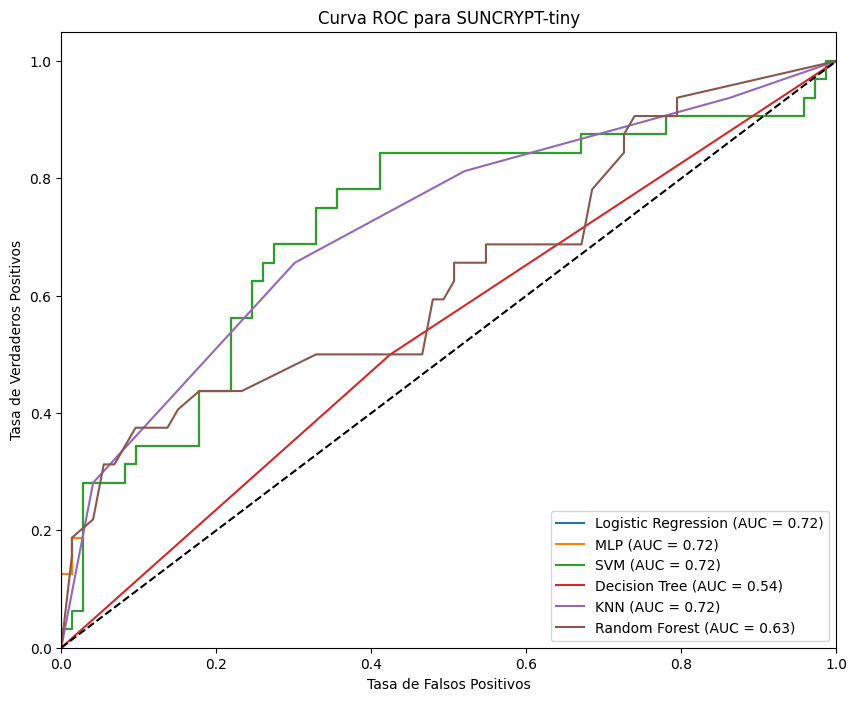

Generando curva ROC para CLOP-tiny...


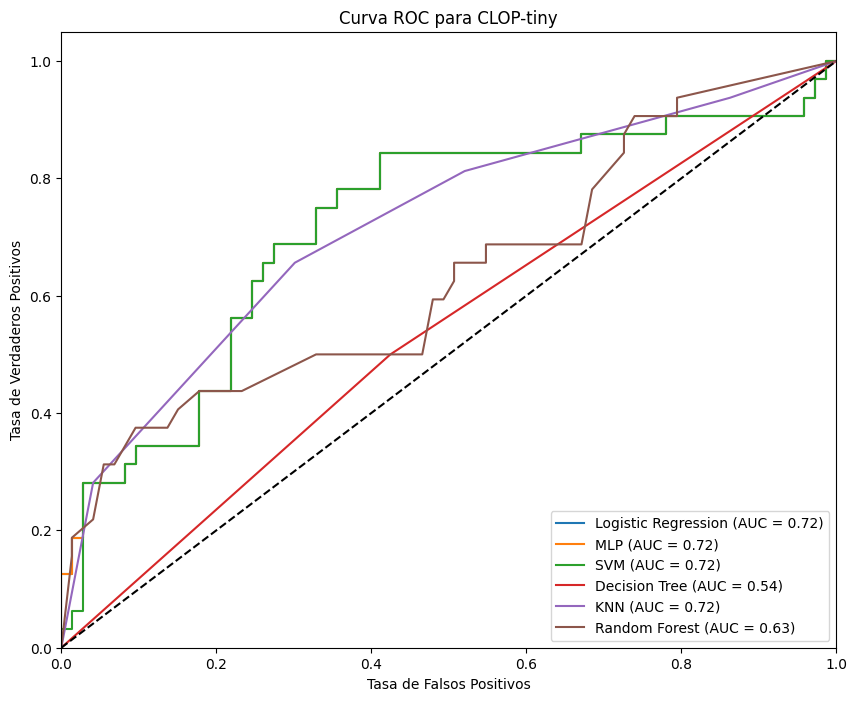

Generando curva ROC para BADRABBIT-tiny...


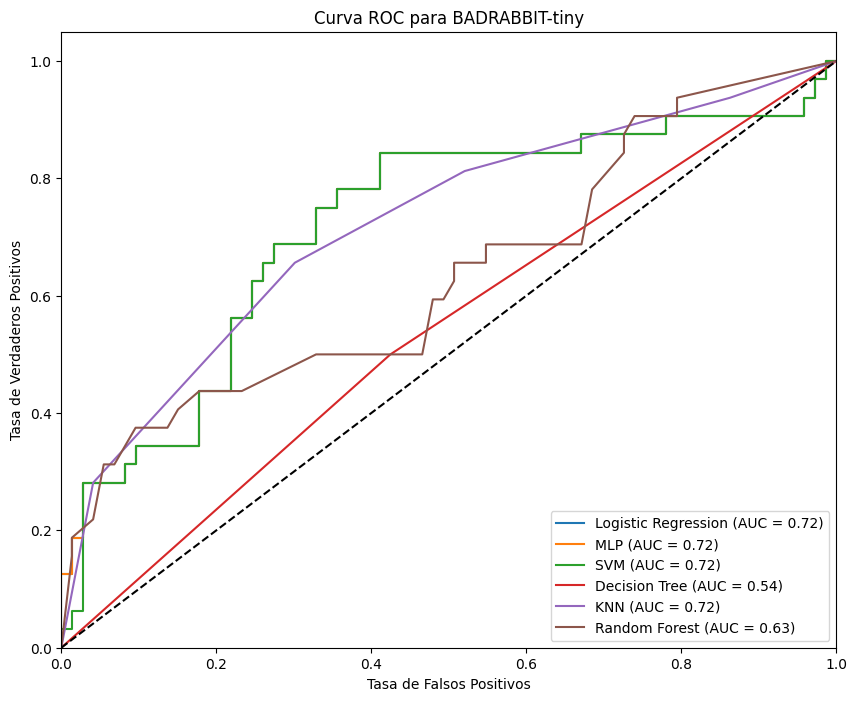

Generando curva ROC para DHARMA-tiny...


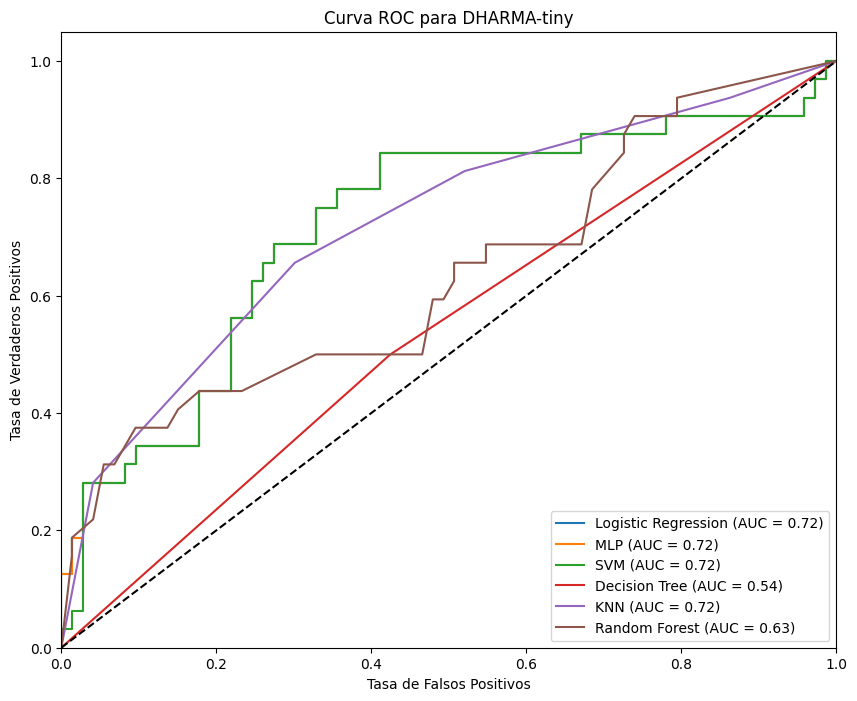

Generando curva ROC para MAZE-tiny...


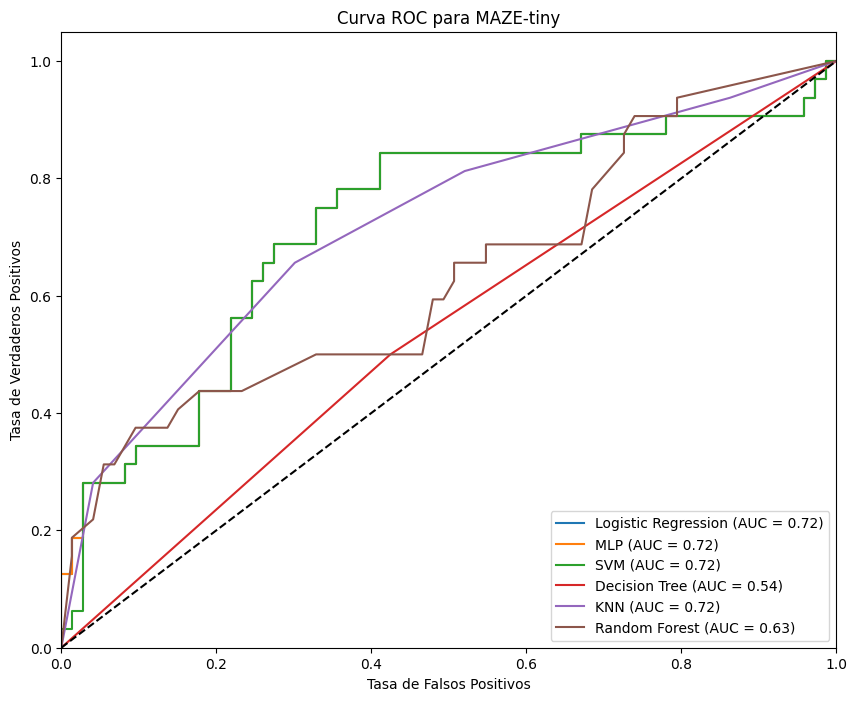

Generando curva ROC para GANDCRAB-tiny...


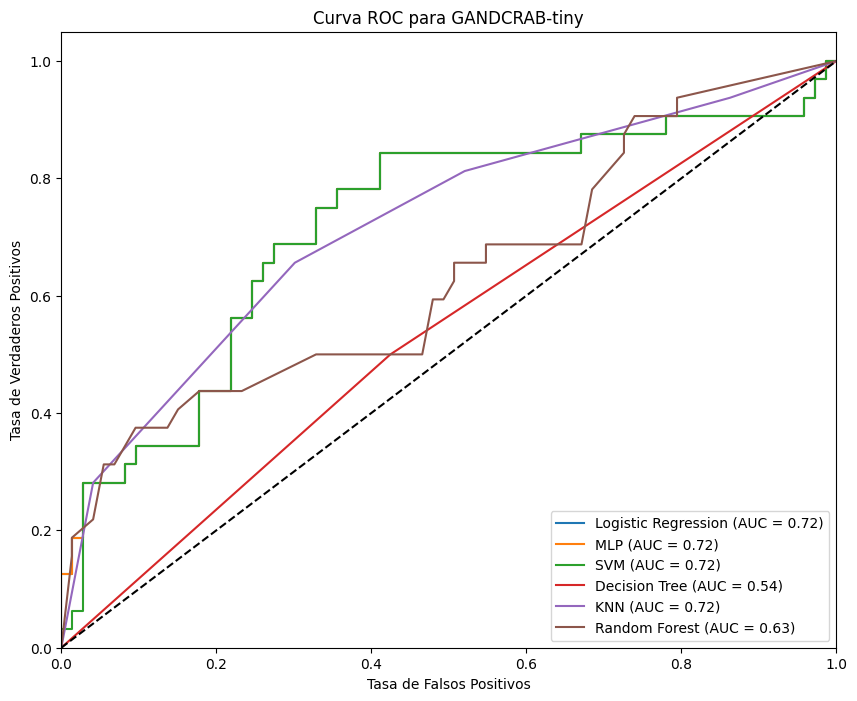

Generando curva ROC para BLACKMATTER-tiny...


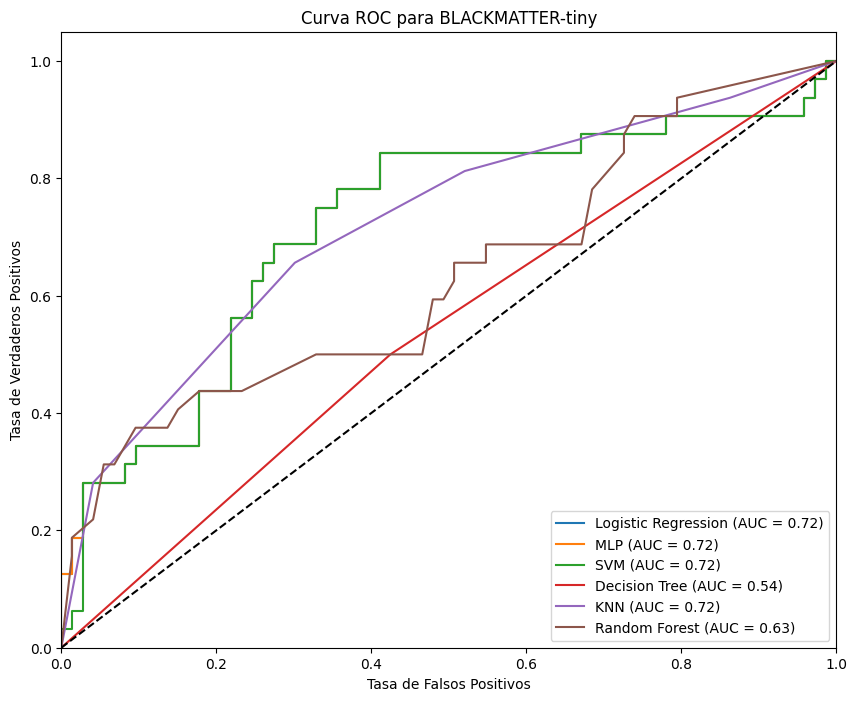

Generando curva ROC para JIGSAW-tiny...


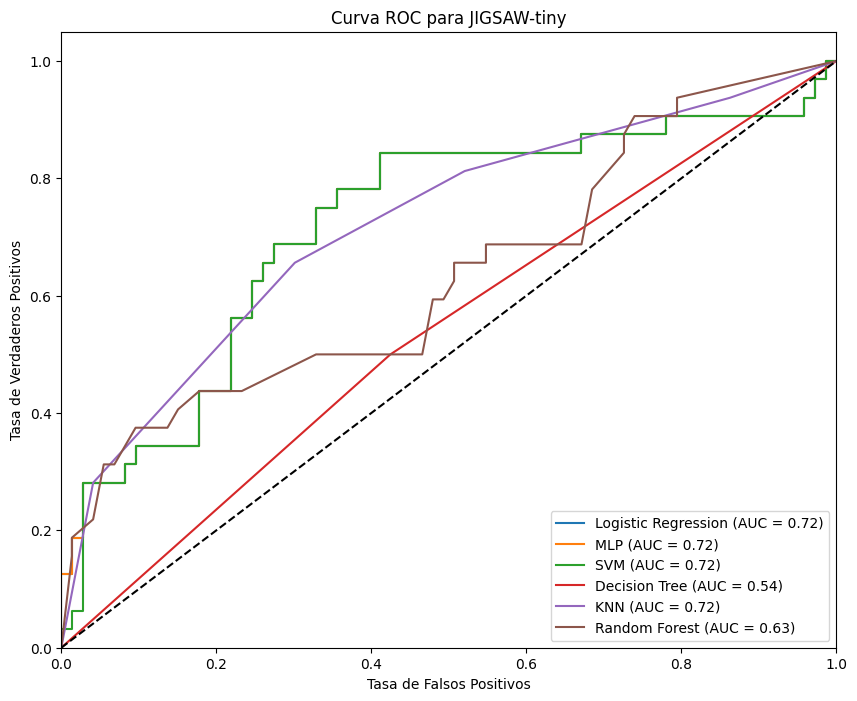

Generando curva ROC para LOCKBIT-tiny...


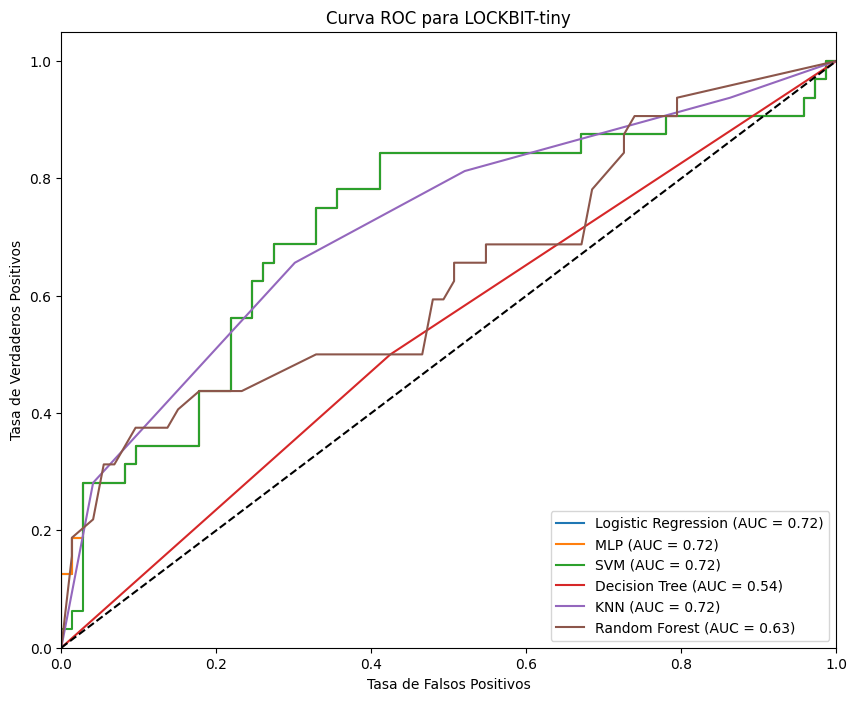

Generando curva ROC para CRYPTOLOCKER-tiny...


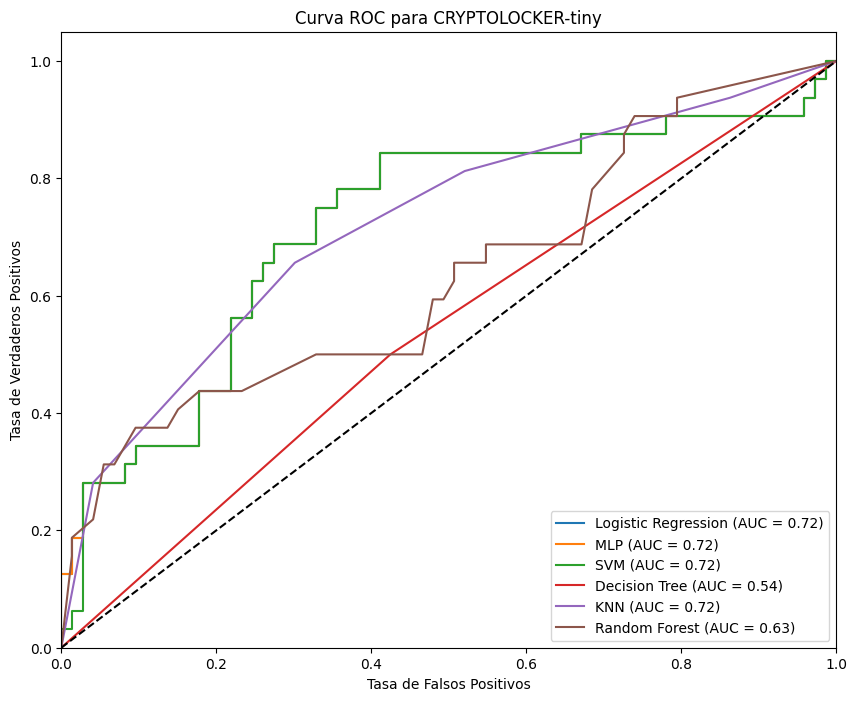

Generando curva ROC para WANNACRY-tiny...


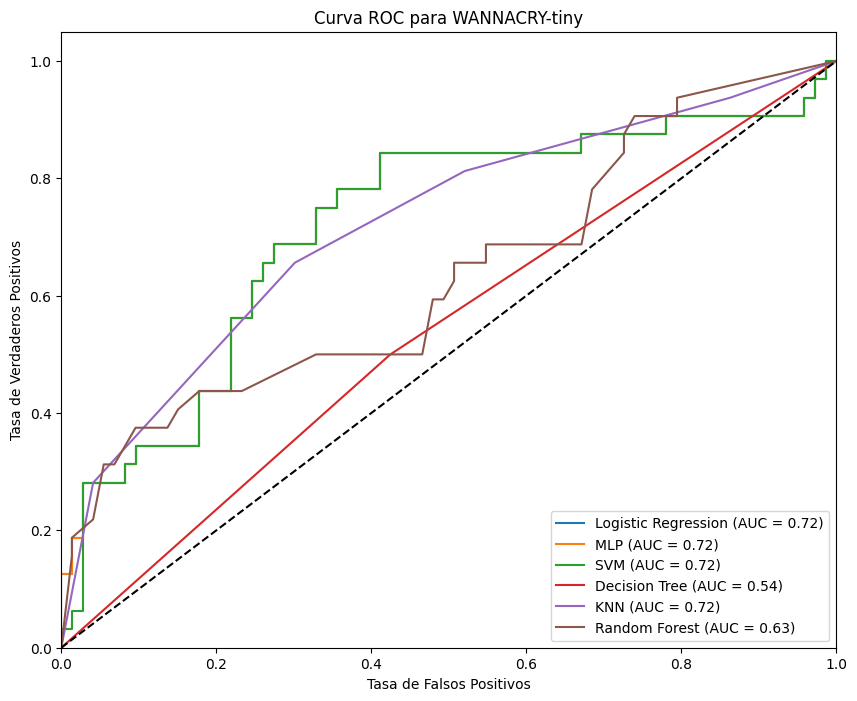

Generando curva ROC para RANSOMEXX-tiny...


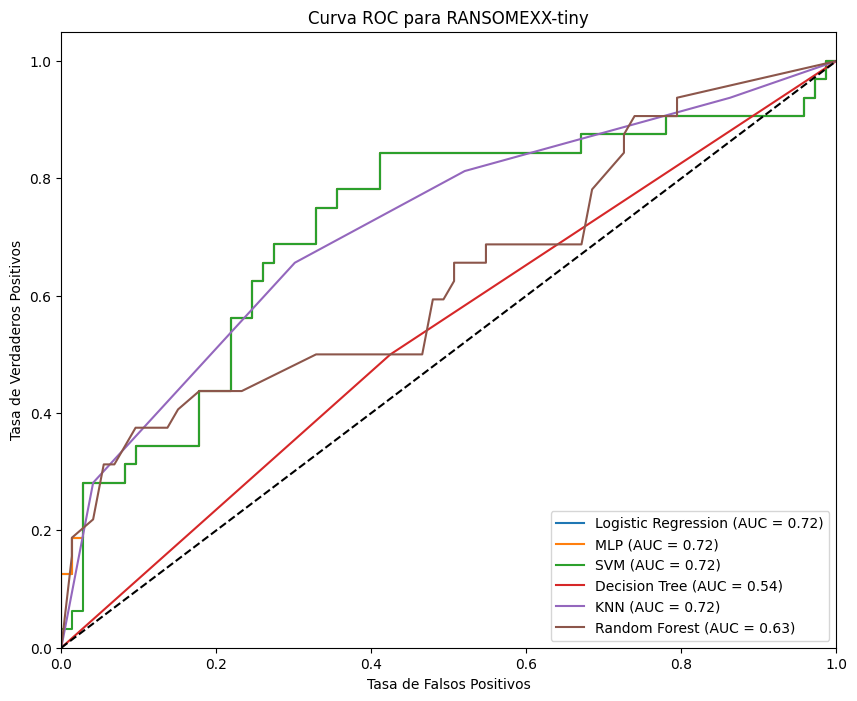

Generando curva ROC para AVOSLOCKER-tiny...


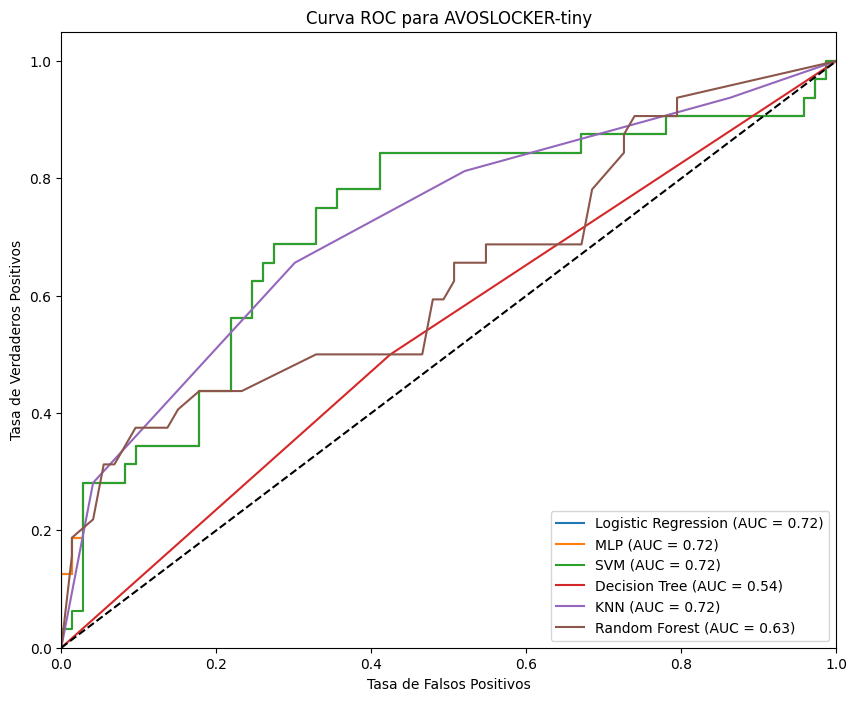

Generando curva ROC para HELLOKITTY-tiny...


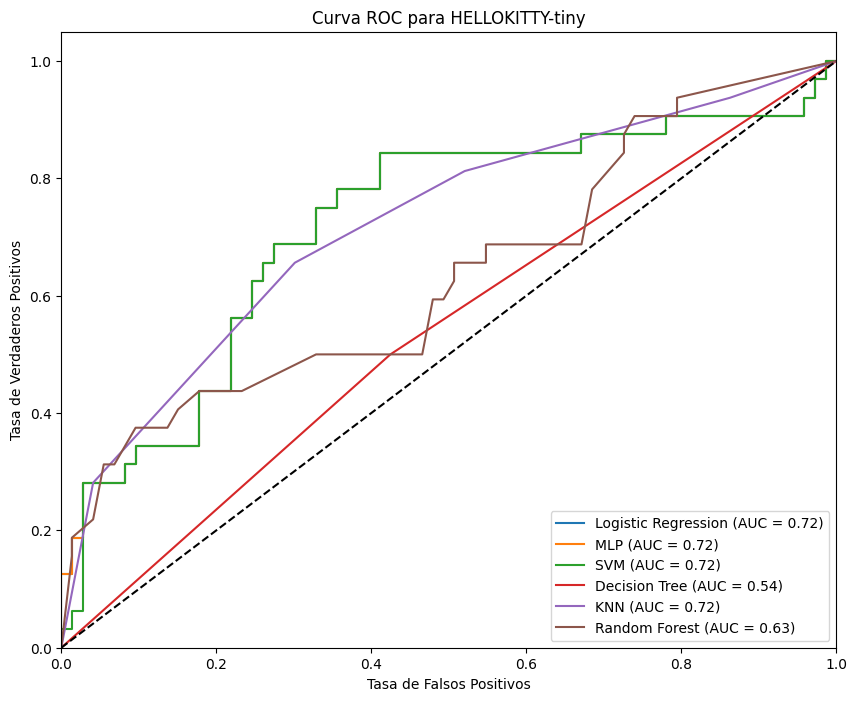

Generando curva ROC para DARKSIDE-tiny...


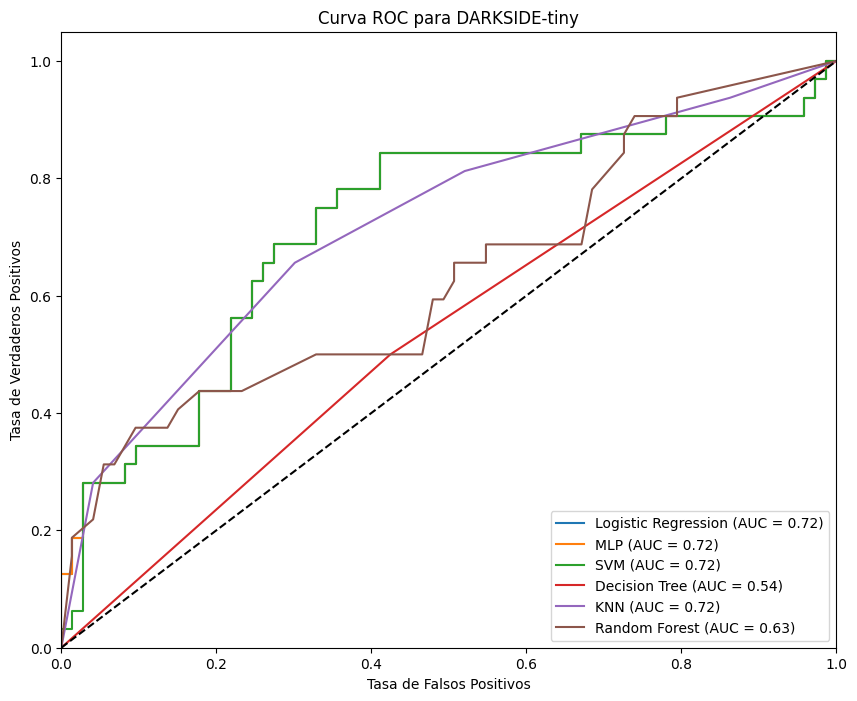

Generando curva ROC para CONTI-tiny...


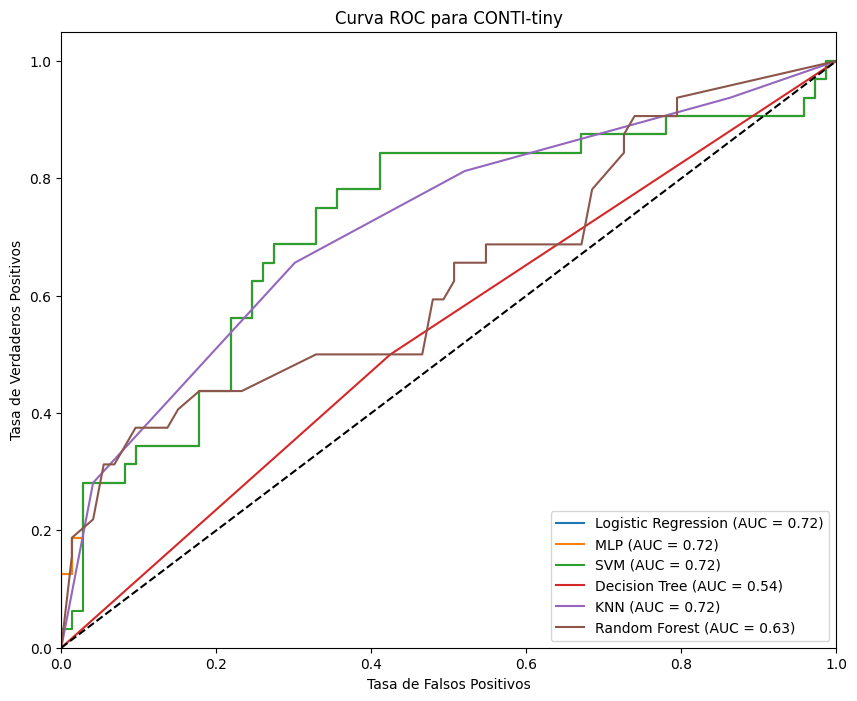

Generando curva ROC para SODINOKIBI-tiny...


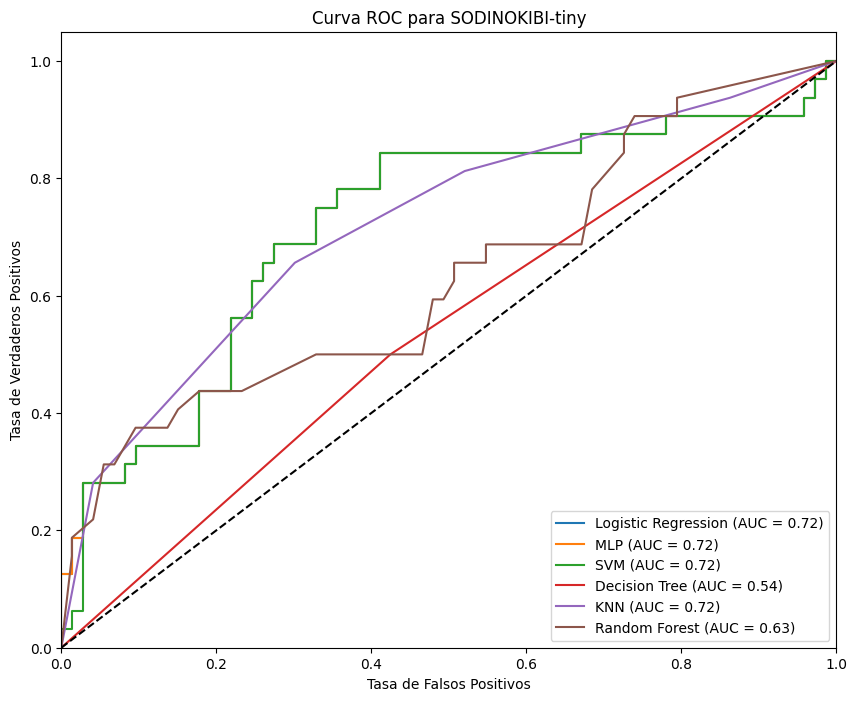

Generando curva ROC para BLACKBASTA-tiny...


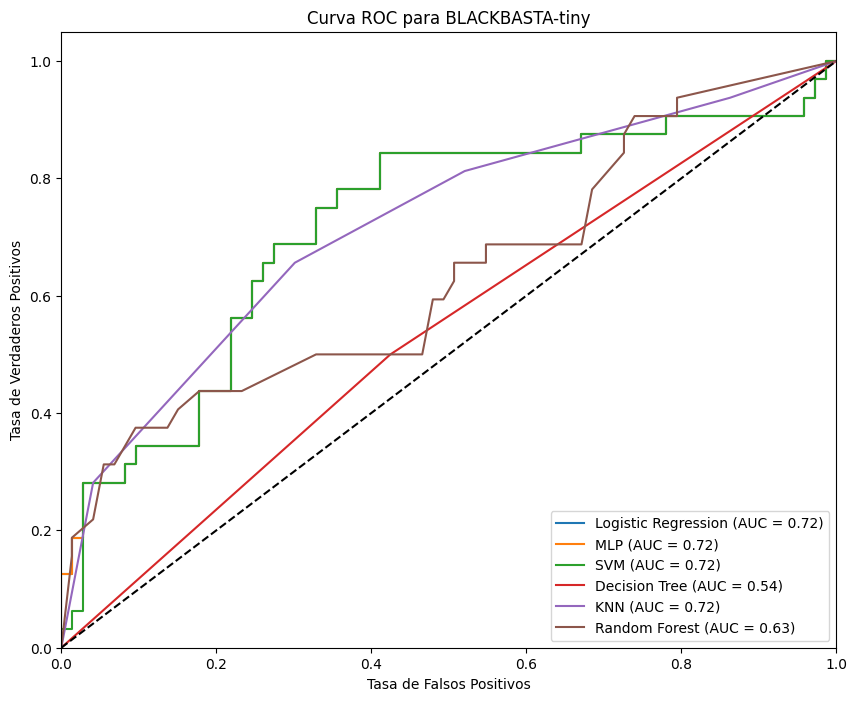

Generando curva ROC para NETWALKER-tiny...


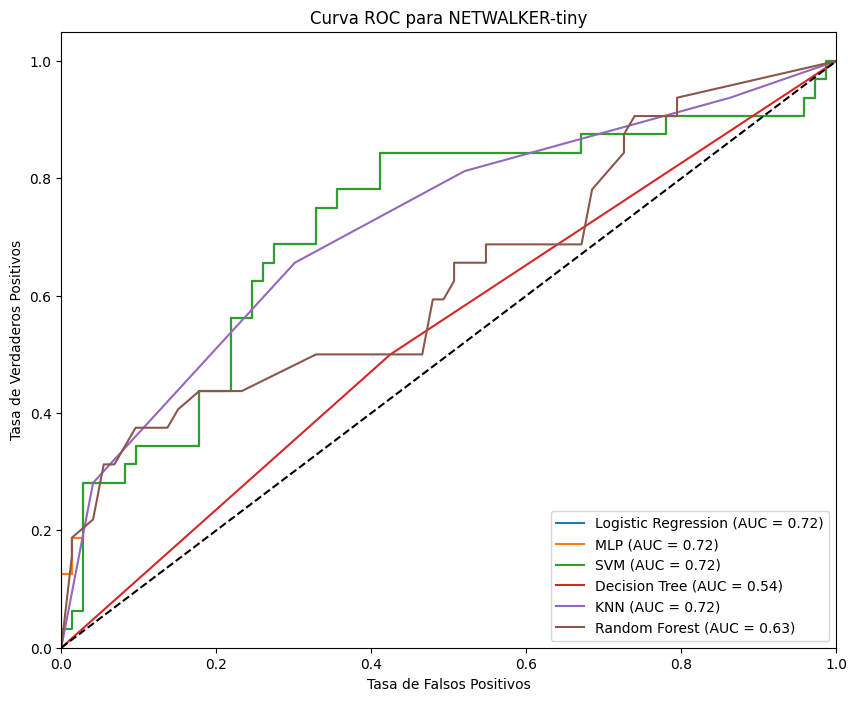

In [47]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


for family in families:
    print(f"Generando curva ROC para {family}...")

    # ... (tu código para obtener características y dividir datos) ...
    # 📌 Obtener características de ransomware
    family_features = []
    family_labels = []

    family_path = os.path.join(EXTRACT_PATH, family)
    for file in os.listdir(family_path):
        file_path = os.path.join(family_path, file)
        features = extract_features(file_path)
        if features:
            family_features.append(features)
            family_labels.append(1)  # 1 = Ransomware

    X = np.vstack((clean_features, family_features))

    # Diccionario para almacenar las curvas ROC de cada modelo
    roc_curves = {}

    for model_name, model in models.items():
        # Calcular la curva ROC
        y_score = model.predict_proba(X_test)[:, 1]  # Probabilidades para la clase positiva (ransomware)
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)

        # Almacenar la curva ROC y el AUC
        roc_curves[model_name] = (fpr, tpr, roc_auc)

    # Graficar las curvas ROC
    plt.figure(figsize=(10, 8))
    for model_name, (fpr, tpr, roc_auc) in roc_curves.items():
        plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], 'k--')  # Línea diagonal (clasificador aleatorio)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("Tasa de Falsos Positivos")
    plt.ylabel("Tasa de Verdaderos Positivos")
    plt.title(f"Curva ROC para {family}")
    plt.legend(loc="lower right")
    plt.show()